# Volume 3: K-Means Clustering.

Caelan Osman

Math 403

November 23, 2021

In [97]:
import numpy as np
from scipy.linalg import norm
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.base import ClusterMixin
from scipy.spatial import distance_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import cluster
from imageio import imread
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams["figure.dpi"] = 200

## Problem 1

Write a `KMeans` class for doing basic $k$-means clustering.
Implement the following methods, following `sklearn` class conventions.
1. `__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

2. `fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.
Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.

3. `predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$th entry indicates which cluster center the $i$th row of $X$ is closest to.

Test your class on the iris data set (`sklean.datasets.load_iris()`) after reducing the data to two principal components (with `sklearn.decomposition.PCA`).
Plot the data, coloring by cluster.

In [47]:
class KMeans(BaseEstimator, ClusterMixin):
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, normalize=False, p=2):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize        # This is for Problem 2.
        self.p = p
    
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """

        #get number of rows of X
        m, _ = X.shape
        #set array of row indices
        row_indices = np.arange(0, m)
        #get random set of rows
        cluster_means = X[np.random.choice(row_indices, size=self.n_clusters)]
        #get the new means
        for i in range(self.max_iter):
            new_cluster_means = np.array([
                np.mean(
                    X [
                        np.argsort(
                            distance_matrix(
                                X, cluster_means, p=self.p
                            )
                        )
                        [ :, 0 ]  == i
                    ],
                    axis=0
                )
                for i in range( self.n_clusters )
            ])
            #check for empty or infs
            for j, row in enumerate(new_cluster_means):
                #if there are any get a new random choice
                if np.any(np.isnan(row)) or np.any(np.isinf(row)):
                    new_cluster_means[j] = X[np.random.choice(row_indices, size=1)]
            if self.normalize:
                new_cluster_means /= norm(new_cluster_means, ord=2, axis=1)[:, np.newaxis]
            #check convergence
            if norm(cluster_means - new_cluster_means, ord=self.p) < self.tol:
                break
            cluster_means = new_cluster_means.copy()

        #set attirbute
        self.cluster_centers = cluster_means
        return self
    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters for each entry of X.
        """
        #get shape of X
        L, _ = X.shape
        #initialize prediction array
        prediction = np.zeros(L)
        #get all predictions
        for l in range(L):
            #set current min distance and min index
            min_distance = np.inf
            min_index = 0
            #iterate through all cluster centers
            for i, center in enumerate(self.cluster_centers):
                #get current distance
                cur_distance = norm(X[l] - center, ord=self.p)
                #check condition
                if cur_distance < min_distance:
                    min_distance = cur_distance
                    min_index = i
            #set prediction
            prediction[l] = min_index

        return prediction

    def fit_predict(self, X, y=None):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)

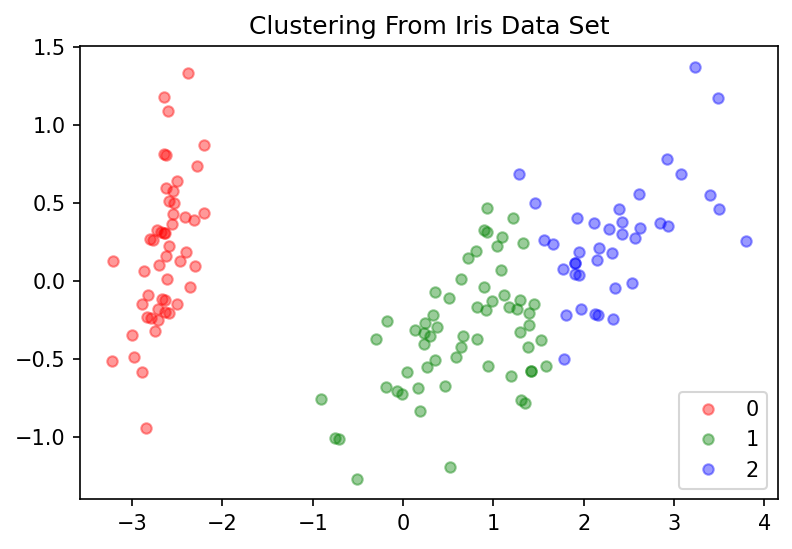

In [40]:
def test_kmeans():
    #load data set
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    #perform PCA
    pca = PCA( n_components=2 )
    Xhat = pca.fit_transform(X)
    #Kmenas with 3 clusters
    KM = KMeans(n_clusters=3)
    #fit
    KM.fit(Xhat)
    #get predictions and masks
    predictions = KM.predict(Xhat)
    mask0 = predictions == 0
    mask1 = predictions == 1
    mask2 = predictions == 2
    #plot the clusters
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(Xhat[mask0, 0], Xhat[mask0, 1], 'ro', alpha = 0.4, markersize=5, label='0')
    ax.plot(Xhat[mask1, 0], Xhat[mask1, 1], 'go', alpha = 0.4, markersize=5, label='1')
    ax.plot(Xhat[mask2, 0], Xhat[mask2, 1], 'bo', alpha = 0.4, markersize=5, label='2')
    ax.set_title('Clustering From Iris Data Set')
    ax.legend(loc='best')
    plt.show()

    return

test_kmeans()

## Problem 2

Modify `KMeansfit()` to take in a paramter `p` which gives us the norm to be used.

Import and parse the Sacramento housing data.
1. Use your `KMeans` class with a chosen `norm` on the housing data, let n=12.
2. Experiment with different norms.
3. Plot the data, coloring by cluster.
Also mark the cluster centers.
In a Markdown cell explain which norm is best for decreasing the longest distance to farthest home.

distances:
[0.45334288 0.44571137 0.44571137]
Best Norm:
2


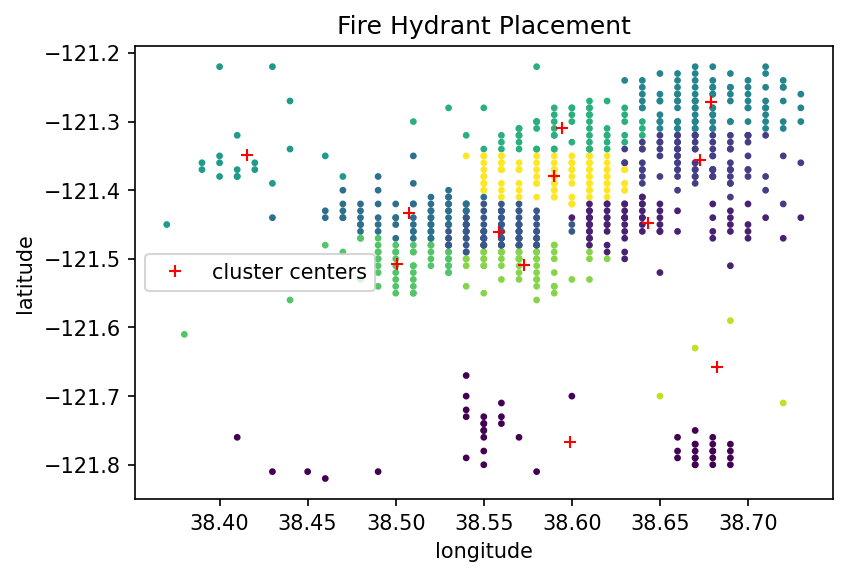

In [41]:
def problem2():
    norms = [1, 2, np.inf]
    X = np.load('sacramento.npy')[:, -2:]
    
    min_max_distance = np.inf
    distances = np.zeros(3)
    best_norm = 0
    for k, n in enumerate(norms):
        max_distances = np.empty(40)
        for j in range(40):
            curr_farthest = 0
            KM = KMeans(n_clusters=12, p=n)
            KM.fit(X)
            pred = KM.predict(X)
            for i in pred:
                cluster = KM.cluster_centers[int(round(i))]
                pos = X[int(round(i))]
                dist = norm(cluster - pos, ord = 2)
            
                if dist > curr_farthest:
                    curr_farthest = dist
            max_distances[j] = curr_farthest
                
        if np.mean(max_distances) < min_max_distance:
            min_max_distance = np.mean(max_distances)
            best_norm = n
        distances[k] = min_max_distance
    
            
    print('distances:', distances, sep='\n')
    print('Best Norm:', best_norm, sep='\n')
    KM = KMeans(n_clusters=12, p=best_norm)
    KM.fit(X)
    pred = KM.predict(X)
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0], X[:, 1], c=pred, s=5)
    ax.plot(KM.cluster_centers[:, 0], KM.cluster_centers[:, 1], 'r+', label='cluster centers')
    ax.set_title('Fire Hydrant Placement')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.legend(loc='best')
    plt.show()
    return

problem2()

As we can see above we got the infinity norm as the best norm to minimize the distance between the house that's the farthest away and the cluster center. This should make intuitive sense as the ininity norm is taking the supremum over all the values so we're minimizing the supremum.

# Problem 3

Modify `KMeans.fit()` so that if `normalize` is `True`, the cluster centers are normalized at each iteration.

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
1. Convert longitude and latitude to radians, then to spherical coordinates.
(Hint: `np.deg2rad()` may be helpful.)
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use your `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.
5. Plot the data, coloring by cluster.
Also mark the cluster centers.

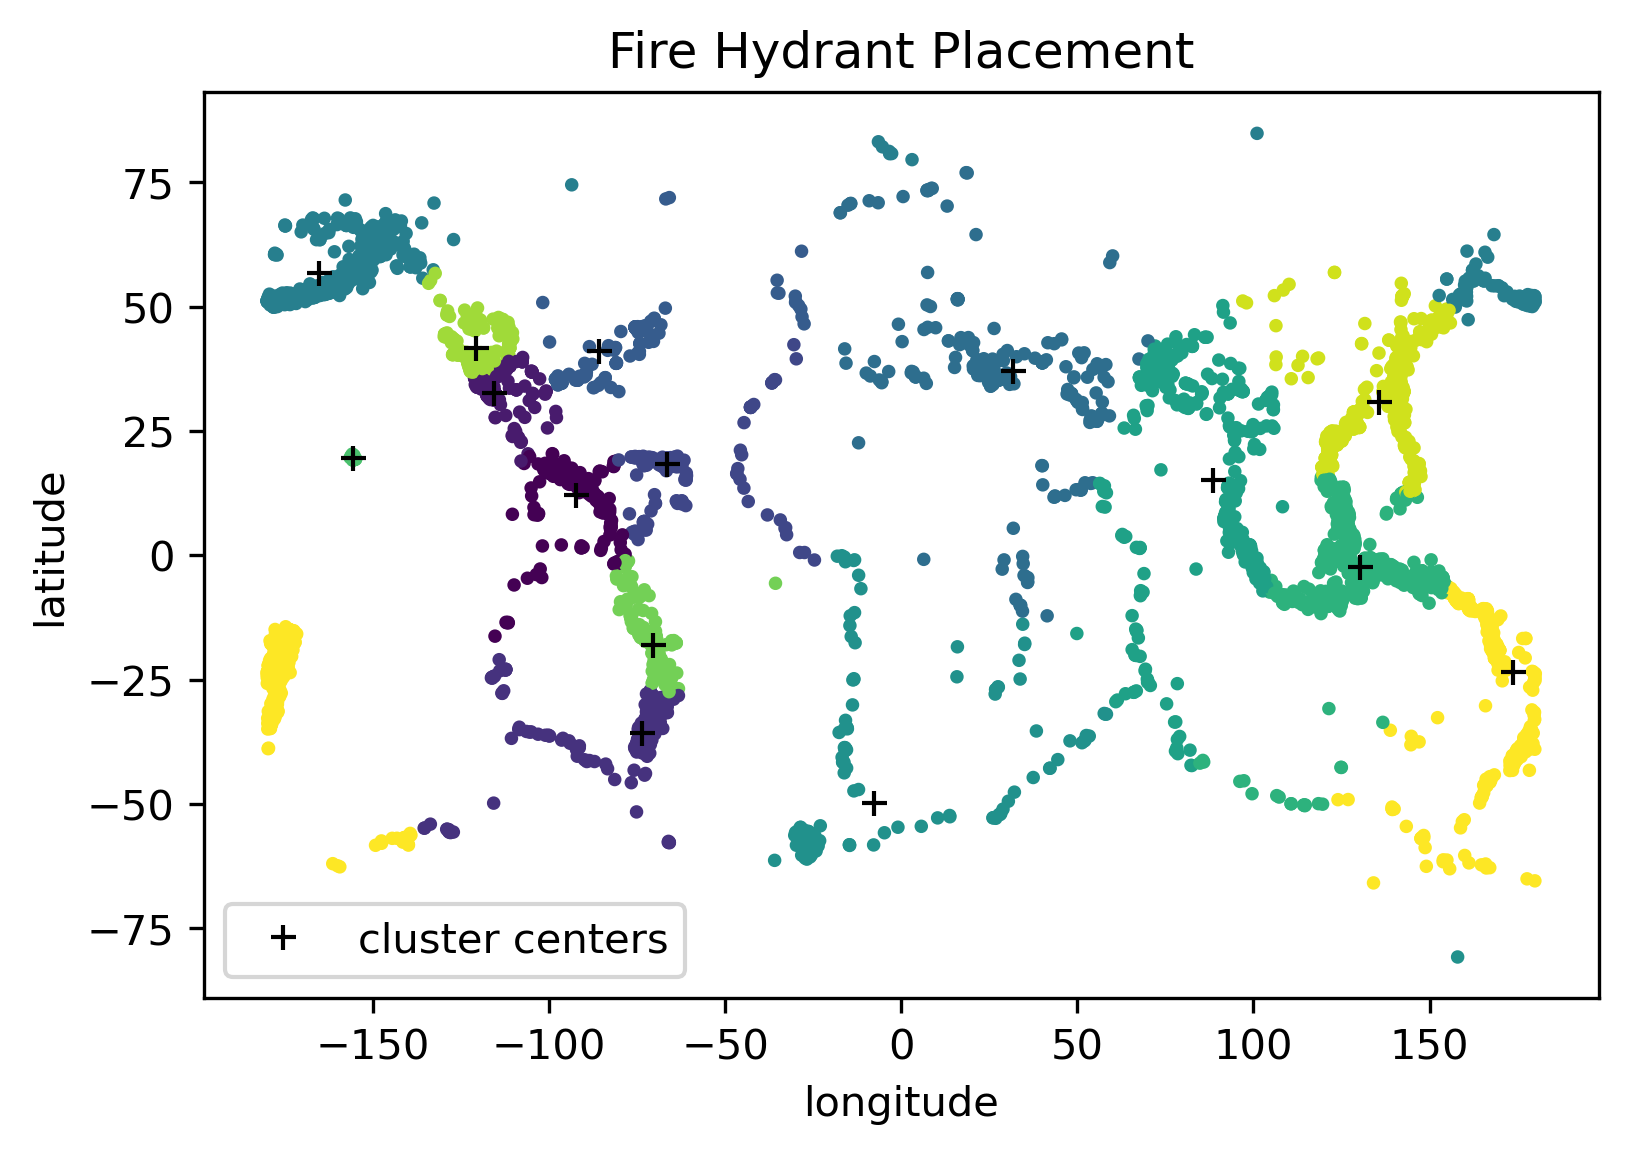

In [48]:
def problem3():
    EQ = np.load('earthquake_coordinates.npy')
    #get degree matrix
    degs = np.zeros_like(EQ)
    degs[:, 0] = np.deg2rad(EQ[:, 0])
    degs[:, 1] = np.deg2rad(90 - EQ[:, 1])
    #get euclidean coordinates
    Euclid = np.zeros((degs.shape[0], 3))
    Euclid[:, 0] = np.sin(degs[:, 1])*np.cos(degs[:, 0])
    Euclid[:, 1] = np.sin(degs[:, 1])*np.sin(degs[:, 0])
    Euclid[:, 2] = np.cos(degs[:, 1])

    KM = KMeans(n_clusters=15, normalize=True)
    KM.fit(Euclid)
    pred = KM.predict(Euclid)

    #get the centers
    centers = KM.cluster_centers
    #translate cluster centers coordinates
    Spherical = np.zeros((centers.shape[0], 2))
    Spherical[:, 0] = np.arctan2(centers[:, 1], centers[:, 0])
    Spherical[:, 1] = np.arccos(centers[:, 2])
    #make the coordinates radians
    Spherical[:, 0] = np.rad2deg(Spherical[:, 0])
    Spherical[:, 1] = 90 - np.rad2deg(Spherical[:, 1])

    fig = plt.figure()
    fig.set_dpi(300)
    ax = fig.add_subplot(111)
    ax.scatter(EQ[:, 0], EQ[:, 1], c=pred, s=5)
    ax.plot(Spherical[:, 0], Spherical[:, 1], 'k+', label='cluster centers')
    ax.set_title('Fire Hydrant Placement')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.legend(loc='best')
    plt.show()

    return

problem3()

## Problem 4

Write a function that accepts an image array (of shape $(m,n,3)$), an integer number of clusters $k$, and an integer number of samples $S$.
Reshape the image so that each row represents a single pixel.
Choose $S$ pixels to train a $k$-means model on with $k$ clusters.
Make a copy of the original picture where each pixel has the same color as its cluster center.
Return the new image.
For this problem, you may use `sklearn.cluster.KMeans` instead of your `KMeans` class.

Test your function on some of the provided NASA images.

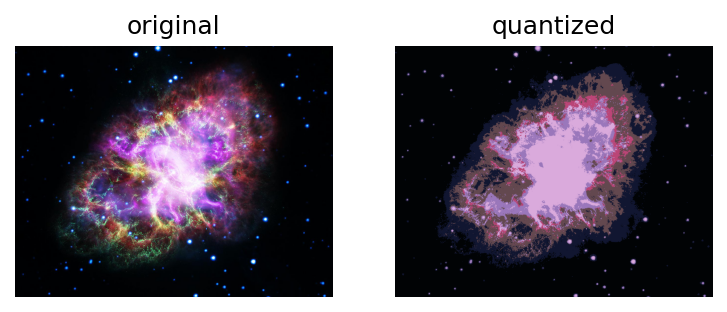

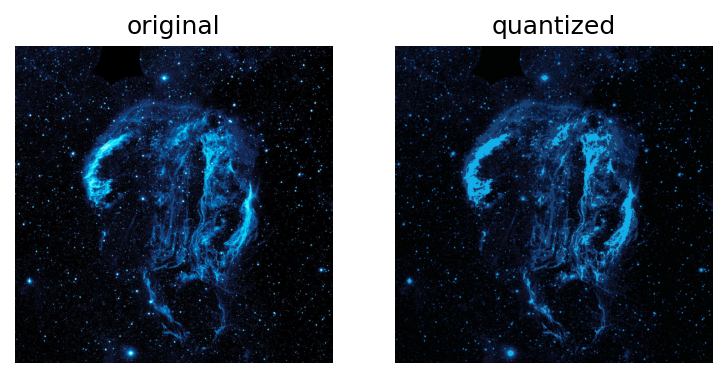

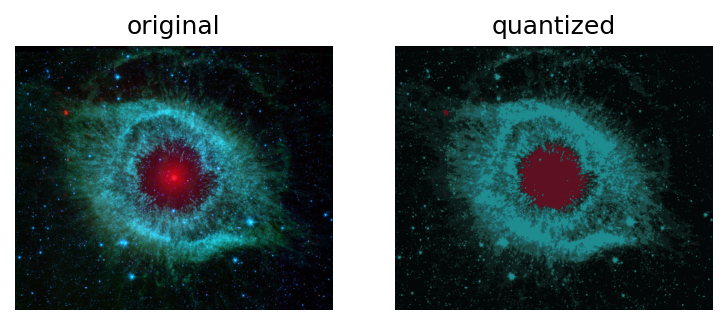

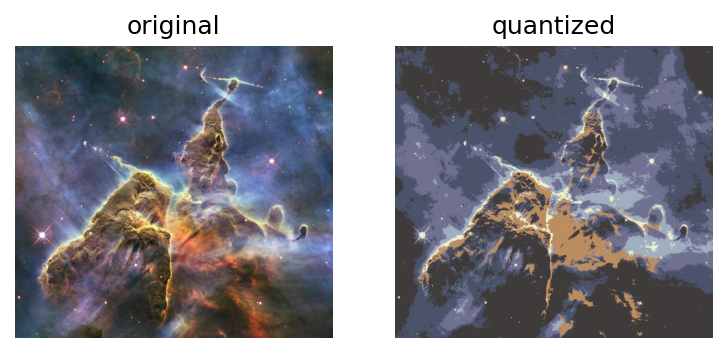

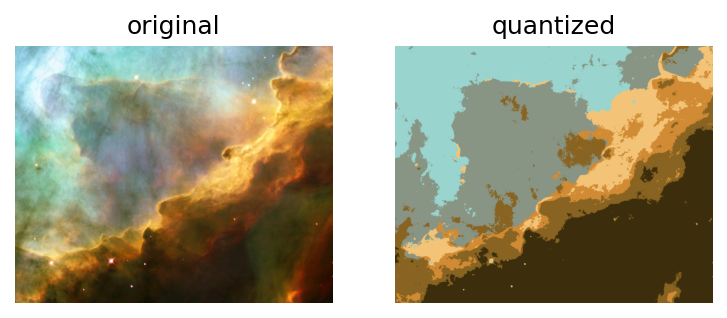

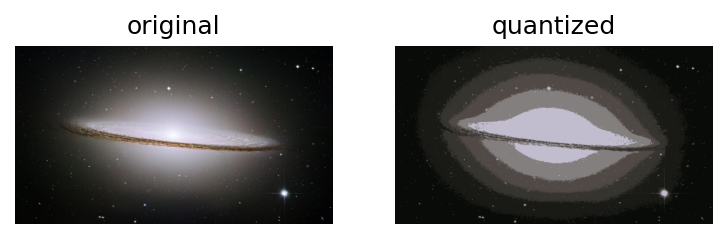

In [93]:
def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    m, n, k = im.shape
    image = np.reshape(im, (m*n, 3))

    pixels = np.random.randint(low=0,high=image.shape[0], size=50 )

    KM = cluster.KMeans(n_clusters=n_clusters)
    KM.fit(image[pixels])
    pred = KM.predict(image)

    new_image = np.zeros_like(image)
    for i, col in enumerate(pred):
        new_image[i, :] = KM.cluster_centers_[int(round(col))]


    return np.reshape(new_image, (m, n, 3))


def problem4():

    files = ['nasa/crab_nebula.jpg', 'nasa/cygnus_loop.jpg', 'nasa/helix_nebula.jpg',
             'nasa/mystic_mountain.jpg', 'nasa/omega_nebula.jpg', 'nasa/sombrero.jpg']
    labels = ['crab nebula', 'cygnus loop', 'helix nebula', 'mystic mountain',
                'omega nebula', 'sombrero']

    original_images = [imread(file) for file in files]
    q_images = [quantize_image(image, n_clusters=6) for image in original_images]

    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(121)
    ax.imshow(original_images[0])
    ax.set_title('original')
    ax.axis('off')
    ax = fig.add_subplot(122)
    ax.imshow(q_images[0])
    ax.set_title('quantized')
    ax.axis('off')
    plt.show()

    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(121)
    ax.imshow(original_images[1])
    ax.set_title('original')
    ax.axis('off')
    ax = fig.add_subplot(122)
    ax.imshow(q_images[1])
    ax.set_title('quantized')
    ax.axis('off')
    plt.show()

    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(121)
    ax.imshow(original_images[2])
    ax.set_title('original')
    ax.axis('off')
    ax = fig.add_subplot(122)
    ax.imshow(q_images[2])
    ax.set_title('quantized')
    ax.axis('off')
    plt.show()

    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(121)
    ax.imshow(original_images[3])
    ax.set_title('original')
    ax.axis('off')
    ax = fig.add_subplot(122)
    ax.imshow(q_images[3])
    ax.set_title('quantized')
    ax.axis('off')
    plt.show()

    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(121)
    ax.imshow(original_images[4])
    ax.set_title('original')
    ax.axis('off')
    ax = fig.add_subplot(122)
    ax.imshow(q_images[4])
    ax.set_title('quantized')
    ax.axis('off')
    plt.show()

    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(121)
    ax.imshow(original_images[5])
    ax.set_title('original')
    ax.axis('off')
    ax = fig.add_subplot(122)
    ax.imshow(q_images[5])
    ax.set_title('quantized')
    ax.axis('off')
    plt.show()

    return

problem4()